In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from thor.utils import unpackMPCDesignation

%matplotlib inline

np.random.seed(42)

Read S3C files created by Sam and Siegfried.

In [2]:
DATA_DIR = "../data"
S3C_files = sorted(glob.glob(os.path.join(DATA_DIR, "s3c","S*.dat.csv")))
print(S3C_files)

['../data/s3c/S0.dat.csv', '../data/s3c/S1_00.dat.csv', '../data/s3c/S1_01.dat.csv', '../data/s3c/S1_02.dat.csv', '../data/s3c/S1_03.dat.csv', '../data/s3c/S1_04.dat.csv', '../data/s3c/S1_05.dat.csv', '../data/s3c/S1_06.dat.csv', '../data/s3c/S1_07.dat.csv', '../data/s3c/S1_08.dat.csv', '../data/s3c/S1_09.dat.csv', '../data/s3c/S1_10.dat.csv', '../data/s3c/S1_11.dat.csv', '../data/s3c/S1_12.dat.csv', '../data/s3c/S1_13.dat.csv', '../data/s3c/SR.dat.csv', '../data/s3c/SS.dat.csv', '../data/s3c/ST.dat.csv', '../data/s3c/St5.dat.csv']


In [3]:
simulated_observations = []
for f in S3C_files:
    print("Processing file: {}".format(os.path.basename(f)))
    simulated_observations.append(pd.read_csv(f))
    
simulated_observations = pd.concat(simulated_observations)
simulated_observations.sort_values(
    by=["FieldMJD"],
    inplace=True,
)
simulated_observations.reset_index(
    inplace=True,
    drop=True
)
len(simulated_observations)

Processing file: S0.dat.csv
Processing file: S1_00.dat.csv
Processing file: S1_01.dat.csv
Processing file: S1_02.dat.csv
Processing file: S1_03.dat.csv
Processing file: S1_04.dat.csv
Processing file: S1_05.dat.csv
Processing file: S1_06.dat.csv
Processing file: S1_07.dat.csv
Processing file: S1_08.dat.csv
Processing file: S1_09.dat.csv
Processing file: S1_10.dat.csv
Processing file: S1_11.dat.csv
Processing file: S1_12.dat.csv
Processing file: S1_13.dat.csv
Processing file: SR.dat.csv
Processing file: SS.dat.csv
Processing file: ST.dat.csv
Processing file: St5.dat.csv


102658740

In [4]:
simulated_observations["FieldMJD"].max() - simulated_observations["FieldMJD"].min()

364.1180969999914

Take first 35 days of observations (will reduce to 30 later but just making sure we don't accidentally clip observations).

In [5]:
first_exposure = simulated_observations["FieldMJD"].min()
num_nights = 35

simulated_observations = simulated_observations[
    (simulated_observations["FieldMJD"] >= first_exposure)
    & (simulated_observations["FieldMJD"] < (first_exposure + num_nights))]
len(simulated_observations)

11078773

In [6]:
simulated_observations.head()

,ObjID,observationId,FieldMJD,AstRange(km),AstRangeRate(km/s),AstRA(deg),AstRARate(deg/day),AstDec(deg),AstDecRate(deg/day),Ast-Sun(J2000x)(km),Ast-Sun(J2000y)(km),Ast-Sun(J2000z)(km),Sun-Ast-Obs(deg),V,Filtermag,V(H=0),Filter,AstRASigma(mas),AstDecSigma(mas),PhotometricSigma(mag)
0,S00000pWa,0,59853.985644,1.806609e+08,12.121,293.446584,0.083468,3.515836,-0.215819,2.198797e+08,-1.452112e+08,1.984291e+07,33.042024,21.648,21.247,3.032,z,84.473821,84.473821,0.100685
1,St5002gfa,0,59853.985644,6.933624e+08,23.236,296.078215,0.030682,4.609261,-0.057868,4.519458e+08,-6.005395e+08,6.448260e+07,10.852051,21.854,21.556,7.524,z,111.242671,111.242671,0.131106
2,S1004031a,0,59853.985644,3.110664e+08,17.909,294.549169,0.083839,3.907008,-0.055772,2.770707e+08,-2.620691e+08,2.995922e+07,21.992433,20.471,20.070,4.691,z,31.381618,31.381618,0.036783
3,S1005juya,0,59853.985644,3.307562e+08,18.309,296.153045,0.122852,4.921600,-0.143050,2.933811e+08,-2.755779e+08,3.714040e+07,20.559665,19.839,19.438,4.899,z,20.149531,20.149531,0.021782
4,S1005Q41a,0,59853.985644,3.025812e+08,14.915,294.380587,0.115228,4.948851,-0.170362,2.725697e+08,-2.543499e+08,3.486658e+07,22.510926,21.140,20.739,4.600,z,54.255349,54.255349,0.065081


Calculate H magnitude, then only keep s3m objects with H magnitude >= 15. 

In [7]:
simulated_observations["H"] = simulated_observations["V"] - simulated_observations["V(H=0)"]
simulated_observations = simulated_observations[(simulated_observations["H"] >= 15)].copy()
len(simulated_observations)

10500342

Read MPC files created by Sam and Siegfried. 

In [8]:
MPC_files = sorted(glob.glob(os.path.join(DATA_DIR, "mpc", "MPC*.dat")))
print(MPC_files)

['../data/mpc/MPCDET_1.dat', '../data/mpc/MPCDET_2.dat', '../data/mpc/MPCDET_3.dat', '../data/mpc/MPCDET_4.dat', '../data/mpc/MPCDET_5.dat']


In [9]:
columns = [
    "ObjID",  
    "FieldID",      
    "FieldMJD",  
    "AstRange(km)",  
    "AstRangeRate(km/s)",  
    "AstRA(deg)",  
    "AstRARate(deg/day)",  
    "AstDec(deg)",  
    "AstDecRate(deg/day)",  
    "Ast-Sun(J2000x)(km)",  
    "Ast-Sun(J2000y)(km)",  
    "Ast-Sun(J2000z)(km)",
    "Sun-Ast-Obs(deg)",       
    "V",
    "V(H=0)",
    "Filter",  
    "Filtermag",
    "AstRARate(deg/sec)",  
    "AstDecRate(deg/sec)",  
    "AstRASigma(mas)",  
    "AstDecSigma(mas)",  
    "PhotometricSigma(mag)",  
    "randAstRA(deg)",  
    "randAstDec(deg)",  
    "randFilterMag",
]

dtypes = {}
for col in columns:
    if col in set(["ObjID", "Filter"]):
        dtypes[col] = object
    elif col in set(["FieldID"]):
        dtypes[col] = np.int32
    else:
        dtypes[col] = np.float64

mpc_observations = []
for f in MPC_files:
    print("Processing file: {}".format(os.path.basename(f)))
    
    for df in pd.read_csv(f, delim_whitespace=True, names=columns, dtype=dtypes, chunksize=5000000):
        df.loc[:, "ObjID"] = df["ObjID"].apply(lambda x : x[:-1])
        df = df[
            (df["FieldMJD"] >= first_exposure)
             & (df["FieldMJD"] < first_exposure + num_nights)
        ]
        
        # Set permID and provID after unpacking the designations
        df.loc[:, "ObjID"] = df[~df["ObjID"].isna()]["ObjID"].apply(unpackMPCDesignation)
        df.loc[df["ObjID"].str.isnumeric(), "permID"] = df["ObjID"]
        df.loc[~df["ObjID"].str.isnumeric(), "provID"] = df["ObjID"]
        
        if len(df) != 0:
            mpc_observations.append(df)        
            
mpc_observations = pd.concat(mpc_observations)
mpc_observations.sort_values(
    by=["FieldMJD"],
    inplace=True,
)
mpc_observations.reset_index(
    inplace=True,
    drop=True
)
len(mpc_observations)

Processing file: MPCDET_1.dat
Processing file: MPCDET_2.dat
Processing file: MPCDET_3.dat
Processing file: MPCDET_4.dat
Processing file: MPCDET_5.dat


3606899

In [10]:
len(mpc_observations[mpc_observations["Filter"].isna()])

0

In [11]:
len(mpc_observations[mpc_observations["Filtermag"].isna()])

5862

In [12]:
mpc_observations = mpc_observations[~mpc_observations["Filtermag"].isna()]

Concatenate both sets of observations and sort by exposure time. 

In [13]:
simulated_observations = pd.concat([simulated_observations, mpc_observations])
simulated_observations.sort_values(
    by=["FieldMJD"],
    inplace=True,
)
simulated_observations.reset_index(
    inplace=True,
    drop=True
)
len(simulated_observations)

14101379

Calculate the night of observation.

In [14]:
def calcNight(mjd, midnight=0.166):
    night = mjd + 0.5 - midnight
    return night.astype(int)

simulated_observations["night"] = calcNight(simulated_observations["FieldMJD"])

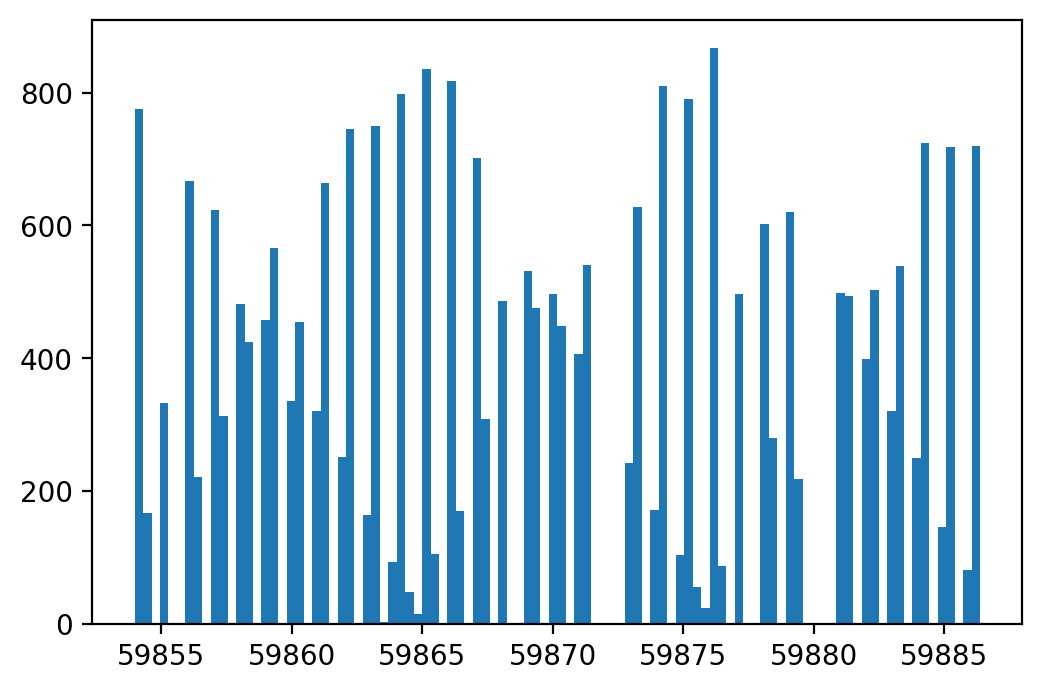

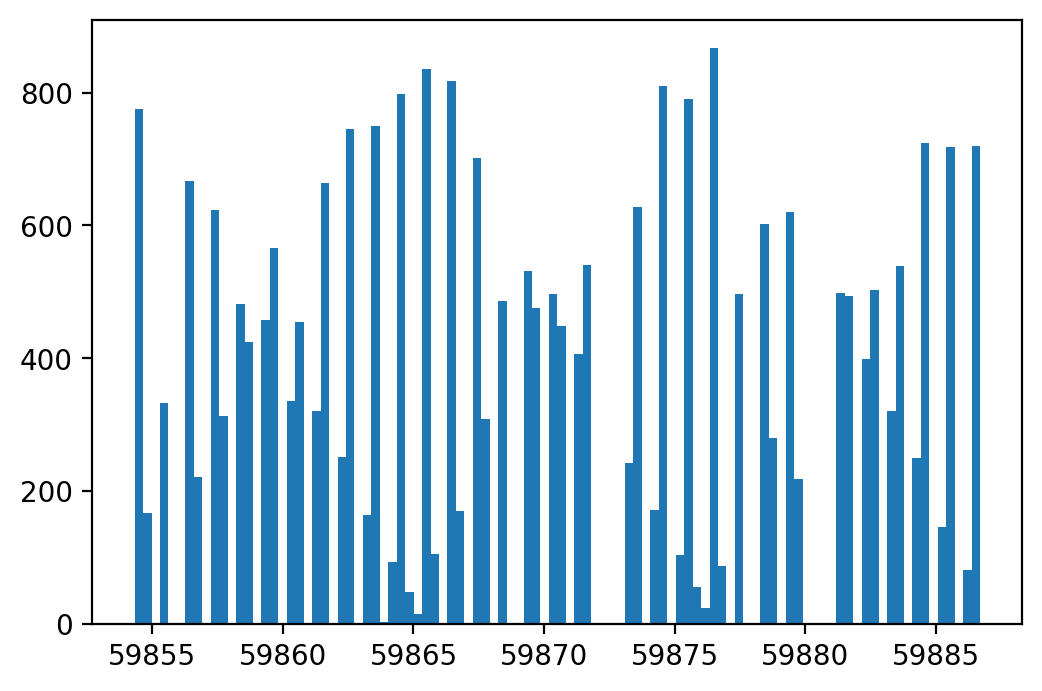

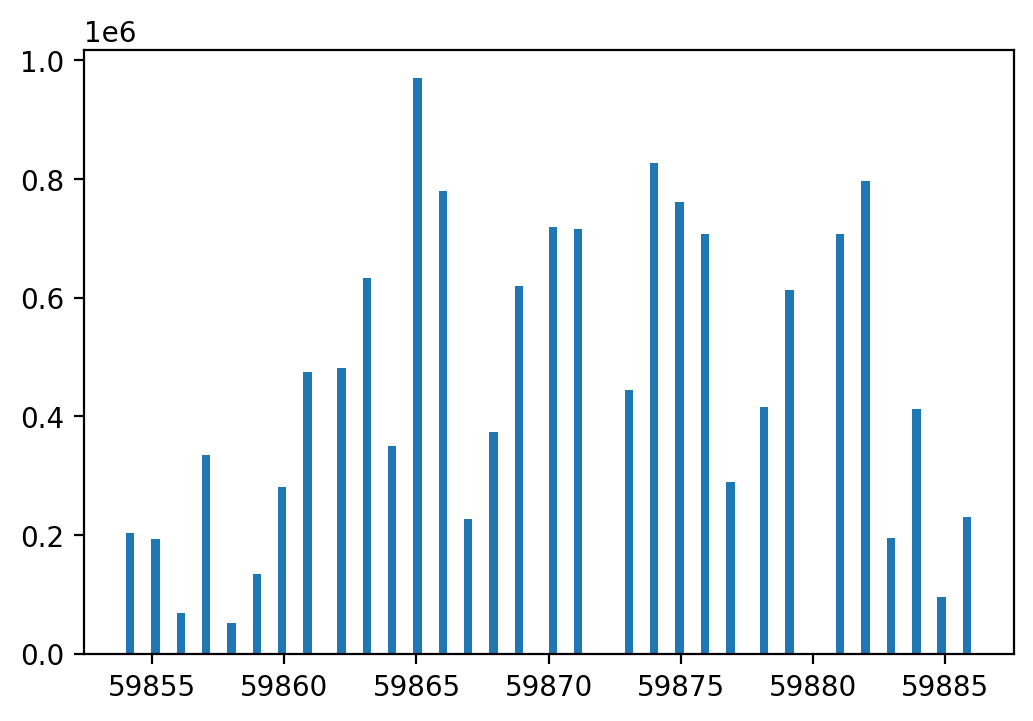

In [15]:
fig, ax = plt.subplots(1, 1, dpi=200)
values, bins, artists = ax.hist(simulated_observations["FieldMJD"].unique(), bins=100)

fig, ax = plt.subplots(1, 1, dpi=200)
values, bins, artists = ax.hist(simulated_observations["FieldMJD"].unique() + 0.5 - 0.166, bins=100)

fig, ax = plt.subplots(1, 1, dpi=200)
values, bins, artists = ax.hist(simulated_observations["night"].values, bins=100)

Keep only the first 30 nights of observations.

In [16]:
simulated_observations = simulated_observations[
    (simulated_observations["night"] >= simulated_observations["night"].min())
    & (simulated_observations["night"] <= (simulated_observations["night"].min() + 30))
].copy()
len(simulated_observations)

13775715

ADES expects rmsRAcosDec.

In [17]:
simulated_observations.loc[:, "AstRASigma(mas)"] *= np.cos(np.radians(simulated_observations["AstDec(deg)"].values))

ADES expects errors in arcseconds.

In [18]:
simulated_observations["AstRASigma(arcsec)"] = simulated_observations["AstRASigma(mas)"].values / 1e3
simulated_observations["AstDecSigma(arcsec)"] = simulated_observations["AstDecSigma(mas)"].values / 1e3

Make sure observation IDs are unique.

In [19]:
simulated_observations["observationId"] = ["obs{:08d}".format(i) for i in range(len(simulated_observations))]

Add observatory code, observation type, astrometric catalog, etc...

In [20]:
simulated_observations["stn"] = ["I11" for i in range(len(simulated_observations))]
simulated_observations["mode"] = ["CCD" for i in range(len(simulated_observations))]
simulated_observations["astCat"] = ["Gaia2" for i in range(len(simulated_observations))]

Rename some columns to fit names expected by ADES. 

In [21]:
simulated_observations.rename(
    columns={
        "observationId" : "obs_id",
        "ObjID" : "obj_id",
        "FieldMJD" : "mjd_utc",
        "AstRA(deg)" : "ra",
        "AstDec(deg)" : "dec",
        "AstRASigma(arcsec)" : "rmsRA", 
        "AstDecSigma(arcsec)" : "rmsDec",
        "Filter" : "band",
        "Filtermag" : "mag",
        "PhotometricSigma(mag)" : "rmsMag",
    },
    inplace=True
)

Create a more accurate representation of an obj_id column without linking: fill it with NaNs. Move the old obj_id column to truth.

In [22]:
simulated_observations.loc[:, "truth"] = simulated_observations["obj_id"].values
simulated_observations.loc[:, "obj_id"] = np.NaN

In [23]:
simulated_observations.head()

,obj_id,obs_id,mjd_utc,AstRange(km),AstRangeRate(km/s),ra,AstRARate(deg/day),dec,AstDecRate(deg/day),Ast-Sun(J2000x)(km),...,randFilterMag,permID,provID,night,rmsRA,rmsDec,stn,mode,astCat,truth
0,NaN,obs00000000,59853.985644,1.806609e+08,12.121,293.446584,0.083468,3.515836,-0.215819,2.198797e+08,...,NaN,NaN,NaN,59854,0.084315,0.084474,I11,CCD,Gaia2,S00000pWa
1,NaN,obs00000001,59853.985644,6.664819e+08,24.005,295.982447,0.025880,3.173436,-0.037195,4.396662e+08,...,18.705318,159342,NaN,59854,0.014006,0.014027,I11,CCD,Gaia2,159342
2,NaN,obs00000002,59853.985644,4.065441e+08,20.394,295.727660,0.058778,4.253158,-0.071506,3.241234e+08,...,21.524440,NaN,2014 WS484,59854,0.115598,0.115917,I11,CCD,Gaia2,2014 WS484
3,NaN,obs00000003,59853.985644,9.389261e+07,-0.045,295.458450,0.078860,5.114469,-0.759084,1.883307e+08,...,18.136846,86666,NaN,59854,0.011877,0.011924,I11,CCD,Gaia2,86666
4,NaN,obs00000004,59853.985644,5.598252e+08,21.715,294.949648,0.033249,6.066039,-0.097057,3.829552e+08,...,23.262118,NaN,2007 VD177,59854,0.559205,0.562354,I11,CCD,Gaia2,2007 VD177


Keep only the relevant columns.

In [24]:
simulated_observations = simulated_observations[[
    "obs_id",
    "obj_id",
    "mjd_utc",
    "ra",
    "dec",
    "rmsRA",
    "rmsDec",
    "band",
    "mag",
    "rmsMag",
    "stn",
    "mode",
    "astCat",
    "night",
    "truth"
]]

In [25]:
simulated_observations.head()

,obs_id,obj_id,mjd_utc,ra,dec,rmsRA,rmsDec,band,mag,rmsMag,stn,mode,astCat,night,truth
0,obs00000000,NaN,59853.985644,293.446584,3.515836,0.084315,0.084474,z,21.247000,0.100685,I11,CCD,Gaia2,59854,S00000pWa
1,obs00000001,NaN,59853.985644,295.982447,3.173436,0.014006,0.014027,z,18.708965,0.012302,I11,CCD,Gaia2,59854,159342
2,obs00000002,NaN,59853.985644,295.727660,4.253158,0.115598,0.115917,z,21.601910,0.136325,I11,CCD,Gaia2,59854,2014 WS484
3,obs00000003,NaN,59853.985644,295.458450,5.114469,0.011877,0.011924,z,18.138789,0.008138,I11,CCD,Gaia2,59854,86666
4,obs00000004,NaN,59853.985644,294.949648,6.066039,0.559205,0.562354,z,23.336774,0.544599,I11,CCD,Gaia2,59854,2007 VD177


In [26]:
simulated_observations.to_csv(
    os.path.join(DATA_DIR, "observations_noErr.txt"), 
    index=False, 
    sep=" "
)

Add random error to the sky-plane positions.

In [27]:
simulated_observations.loc[:, "ra"] = np.random.normal(
    loc=simulated_observations["ra"].values, 
    scale=simulated_observations["rmsRA"].values/3600/np.cos(np.radians(simulated_observations["dec"].values))
)
simulated_observations.loc[:, "dec"] = np.random.normal(
    loc=simulated_observations["dec"].values, 
    scale=simulated_observations["rmsDec"].values/3600
)

# Deal with potential wrap-around issues if adding errors
simulated_observations.loc[simulated_observations["ra"] < 0, "ra"] += 360
simulated_observations.loc[simulated_observations["ra"] > 360, "ra"] -= 360
simulated_observations.loc[simulated_observations["dec"] < -90, "dec"] += 180
simulated_observations.loc[simulated_observations["dec"] > 90, "dec"] -= 180

assert len(simulated_observations[simulated_observations["ra"] < 0]) == 0
assert len(simulated_observations[simulated_observations["ra"] > 360]) == 0
assert len(simulated_observations[simulated_observations["dec"] < -90]) == 0
assert len(simulated_observations[simulated_observations["dec"] > 90]) == 0

In [28]:
simulated_observations.head()

,obs_id,obj_id,mjd_utc,ra,dec,rmsRA,rmsDec,band,mag,rmsMag,stn,mode,astCat,night,truth
0,obs00000000,NaN,59853.985644,293.446596,3.515798,0.084315,0.084474,z,21.247000,0.100685,I11,CCD,Gaia2,59854,S00000pWa
1,obs00000001,NaN,59853.985644,295.982446,3.173437,0.014006,0.014027,z,18.708965,0.012302,I11,CCD,Gaia2,59854,159342
2,obs00000002,NaN,59853.985644,295.727681,4.253175,0.115598,0.115917,z,21.601910,0.136325,I11,CCD,Gaia2,59854,2014 WS484
3,obs00000003,NaN,59853.985644,295.458455,5.114469,0.011877,0.011924,z,18.138789,0.008138,I11,CCD,Gaia2,59854,86666
4,obs00000004,NaN,59853.985644,294.949611,6.066191,0.559205,0.562354,z,23.336774,0.544599,I11,CCD,Gaia2,59854,2007 VD177


In [29]:
simulated_observations.to_csv(
    os.path.join(DATA_DIR, "observations.txt"), 
    index=False, 
    sep=" "
)